# TODO
- Map of tracer selection for kmin
- confirm that EKE signal is not dependent on corrected velocities
- Repeat all the stuff from the analysis notebook
- Should we mask out very low mean gradients?
- Clean up dataset for publishing
- Organize notebooks...(later)
- Write out the raw dataset with all masks included

- For Error estimates: Divide the error by tracer choice by the std instead of the mean - e.g. how much does the error contribute to the diganosed std!

## Questions for analysis...
- It seems like the EKE follows ENSO with a longer lag...maybe a paper?
- Why doesnt the EKEs seasonality translate into the Kmin? diffusivities only appropriate on longer than seasonal timescales?

## For the velocity processing
- The EKE is not affected AT ALL by the correction in the boxes, make a more quantitative comparison for the whole dataset
- 

In [1]:
import xarray as xr
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from xarrayutils.utils import composite
from aviso_surface_tracer import weighted_geometric_mean, weighted_harmonic_mean, harmonic_mean, geometric_mean
from xarrayutils.weighted_operations import weighted_mean
from xarrayutils import concat_dim_da
from mitgcm_surface_tracer.utils import readbin

In [2]:
# Set plot defaults for talk plots!
ax_color = '0.2'
mpl.rc('axes',edgecolor=ax_color, labelcolor=ax_color)
mpl.rc('text',color=ax_color)
mpl.rc('xtick',color=ax_color)
mpl.rc('ytick',color=ax_color)
mpl.rc('ytick',color=ax_color)
mpl.rc('savefig',transparent=True)

In [3]:
from dask.distributed import Client
client = Client(scheduler_file='/rigel/home/jb3210/scheduler.json')

In [4]:
client.restart()

Client Scheduler: tcp://10.43.4.251:8786 Dashboard: http://10.43.4.251:8787/status,Cluster Workers: 47 Cores: 188 Memory: 945.37 GB


# Global input 

In [5]:
Boxes = {
    'North Pacific':{'XC':slice(170,225),'YC':slice(15,45)},
    'South Pacific':{'XC':slice(210,280),'YC':slice(-45,-15)},
         }

In [6]:
# plot specific functions
def xarray_norm(in_a, norm_a):
    out_norm = ((in_a - np.nanmean(in_a.data)) / np.nanstd(in_a.data) *
                np.nanstd(norm_a)) + np.nanmedian(norm_a)
    return out_norm

def xarray_removeSeasonal(da, groupspec='time.month', func=harmonic_mean):
    print('choose the mean function appropriate!!!')
    mean = func(da, 'time')
    season_removed = da.groupby(groupspec).apply(
        lambda x: x - func(x, 'time'), shortcut=False) + mean
    return season_removed.drop(groupspec[5:])

def read_eddyvarbudget(ddir):
    kw = dict(decode_times=False)
    path = os.path.join(ddir,'output_new/0001_global_eddytracervar_budget.nc')
    ds_first = xr.open_dataset(path, **kw)
    ds_first = ds_first.drop(list(ds_first.data_vars)+['time', 'iter'])

    path = os.path.join(ddir,'output_new/*_global_eddytracervar_budget.nc')
    ds_raw = xr.open_mfdataset(path, concat_dim='time', chunks={'tracer_no':1}, **kw,
                               drop_variables=['tracer_no','rA', 'Depth', 'hFacC'])
    ds_raw.update(ds_first)
    if 'tendency' in ds_raw.data_vars:
        ds_raw = ds_raw.drop('tendency') #I forgot to save the tendency in some runs
    ds = ds_raw
    return ds

def _hmean_ufunc(da):
    return harmonic_mean(da, dim='time')

def average_3m(ds):
    tidx = np.arange(len(ds.time)) 
    avg_idx = xr.DataArray((tidx // 3), dims=('time',), coords={'time': ds.time}, name='tidx')
    temp_time = ds.time.groupby(avg_idx).mean().rename({'tidx':'time'})
    
    ave = ds.groupby(avg_idx).mean(dim='time').rename({'tidx':'time'})
    
    # Repeat with harmonic mean for koc
    ave['koc'] = ds['koc'].groupby(avg_idx).apply(_hmean_ufunc).rename({'tidx':'time'})
    
    ave.time.data = temp_time.data
    return ave

def decode_time(ds):
    # Add the correct time.
    ds = ds.copy()
    ds.time.attrs['units'] = 'seconds since 1993-1-1'
    temp = xr.decode_cf(ds.time.to_dataset(name='temp'))
    ds.time.data = temp.time.data
    return ds

def residual_fraction(ds):
    ds = ds.copy()
    numerator = (abs(ds['production'] + ds['dissipation']))
    denominator = (abs(ds_sub['production']) + abs(ds_sub['dissipation']))
    ds['residual_fraction'] = numerator / denominator
    return ds

In [12]:
tracers = ['PSI', 'LAT', 'SST', 'SSS']
datasets = []
for tname in tracers:
    ddir = '/rigel/home/jb3210/jb3210/projects/aviso_surface_tracer/runs/run_KOC_%s_variance_budget_new/' %tname
    ds = read_eddyvarbudget(ddir)
    datasets.append(ds)
ds = xr.concat(datasets, concat_dim_da(tracers, 'tracer'))
ds

<xarray.Dataset>
Dimensions:        (XC: 3600, YC: 1600, time: 292, tracer: 4, tracer_no: 2)
Coordinates:
  * tracer         (tracer) <U3 'PSI' 'LAT' 'SST' 'SSS'
  * time           (time) int64 2592000 5184000 7776000 10368000 12960000 ...
  * tracer_no      (tracer_no) int64 1 2
  * YC             (YC) float32 -79.95 -79.85 -79.75 -79.65 -79.55 -79.45 ...
  * XC             (XC) float32 0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 ...
    rA             (YC, XC) float32 21569878.0 21569878.0 21569878.0 ...
    Depth          (YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    hFacC          (YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    iter           (tracer, time) float64 2.88e+03 5.76e+03 8.64e+03 ...
Data variables:
    production     (tracer, time, tracer_no, YC, XC) float32 dask.array<shape=(4, 292, 2, 1600, 3600), chunksize=(1, 1, 1, 1600, 3600)>
    dissipation    (tracer, time, tracer_no, YC, XC) float32 dask.array<shape=(4, 292, 2, 1600, 3600),

<xarray.Dataset>
Dimensions:    (XC: 360, YC: 160, time: 289)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 1993-03-01 ...
  * YC         (YC) float64 -79.95 -78.95 -77.95 -76.95 -75.95 -74.95 -73.95 ...
  * XC         (XC) float64 0.05 1.05 2.05 3.05 4.05 5.05 6.05 7.05 8.05 ...
Data variables:
    eke        (time, YC, XC) float32 ...
    ubar       (time, YC, XC) float32 nan nan nan nan nan nan nan nan nan ...
    vbar       (time, YC, XC) float32 nan nan nan nan nan nan nan nan nan ...
    eke_corr   (time, YC, XC) float32 ...
    ubar_corr  (time, YC, XC) float32 nan nan nan nan nan nan nan nan nan ...
    vbar_corr  (time, YC, XC) float32 nan nan nan nan nan nan nan nan nan ...

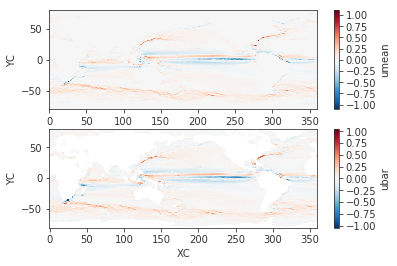

In [13]:
vdir = '/rigel/home/jb3210/jb3210/projects/aviso_products/output_dir'
vel_file = os.path.join(vdir, 'prototype_combined_eke_large_scale.nc')
ds_vel = xr.open_dataset(vel_file)

# I forgot to add the actual time mean flow (I should do this in the separate processing file once this gets cleaned up)
mean_file = os.path.join(vdir, 'prototype_time_mean.nc')
# Why do I need scipy for this to work?
ds_vel_mean = xr.open_dataset(mean_file)#, engine='scipy')

ds_vel_raw = ds_vel.copy()

# Insert mean variables into ds_mean
ds_vel['ubar'] = ds_vel['ubar'] + ds_vel_mean['umean']
ds_vel['vbar'] = ds_vel['vbar'] + ds_vel_mean['vmean']

ds_vel['ubar_corr'] = ds_vel['ubar_corr'] + ds_vel_mean['umean_corr']
ds_vel['vbar_corr'] = ds_vel['vbar_corr'] + ds_vel_mean['vmean_corr']

plt.subplot(2,1,1)
ds_vel_mean['umean'].plot()

plt.subplot(2,1,2)
ds_vel['ubar'].mean('time').plot()

ds_vel

In [14]:
ds_supression = xr.open_dataset('../output/prototype_mixing_supression.nc', engine='scipy')
ds_supression = ds_supression.reindex_like(ds_vel, method='nearest')
ds_supression

<xarray.Dataset>
Dimensions:       (XC: 360, YC: 160, time: 289)
Coordinates:
  * time          (time) datetime64[ns] 1993-01-01 1993-02-01 1993-03-01 ...
  * YC            (YC) float64 -79.95 -78.95 -77.95 -76.95 -75.95 -74.95 ...
  * XC            (XC) float64 0.05 1.05 2.05 3.05 4.05 5.05 6.05 7.05 8.05 ...
Data variables:
    u_bar         (time, YC, XC) float32 nan nan nan nan nan nan nan nan nan ...
    v_bar         (time, YC, XC) float32 nan nan nan nan nan nan nan nan nan ...
    speed_diff_x  (YC, XC, time) float64 nan nan nan nan nan nan nan nan nan ...
    speed_diff_y  (YC, XC, time) float64 nan nan nan nan nan nan nan nan nan ...
    sup_fac_x     (YC, XC, time) float64 nan nan nan nan nan nan nan nan nan ...
    sup_fac_y     (YC, XC, time) float64 nan nan nan nan nan nan nan nan nan ...
    L_mix_x       (YC, XC, time) float64 nan nan nan nan nan nan nan nan nan ...
    L_mix_y       (YC, XC, time) float64 nan nan nan nan nan nan nan nan nan ...
    K_mix_x       (YC, X

/rigel/home/jb3210/code/miniconda/envs/standard/lib/python3.6/site-packages/xarray-0.10.0-py3.6.egg/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


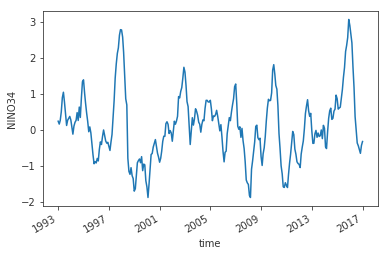

In [15]:
# Load ENSO index (TODO maybe update befor the final release)
ENSO_vel = xr.open_dataset('/rigel/home/jb3210/jb3210/shared_data/climate_indicies/ENSO.nc')
ENSO_vel = ENSO_vel.resample(time='1M').mean().reindex_like(ds_vel, method='nearest') #TODO not sure if this is the best for the correlation...ask Ryan...the signal should be strong anyways
ENSO_vel.NINO34.plot()

In [16]:
ds_vel_composite = composite(ds_vel, ENSO_vel.NINO34, [-1.0, 1.0]).mean('time')
ds_vel_composite

<xarray.Dataset>
Dimensions:    (XC: 360, YC: 160, composite: 3)
Coordinates:
  * YC         (YC) float64 -79.95 -78.95 -77.95 -76.95 -75.95 -74.95 -73.95 ...
  * XC         (XC) float64 0.05 1.05 2.05 3.05 4.05 5.05 6.05 7.05 8.05 ...
  * composite  (composite) <U7 'high' 'neutral' 'low'
Data variables:
    eke        (composite, YC, XC) float32 nan nan nan nan nan nan nan nan ...
    ubar       (composite, YC, XC) float32 nan nan nan nan nan nan nan nan ...
    vbar       (composite, YC, XC) float32 nan nan nan nan nan nan nan nan ...
    eke_corr   (composite, YC, XC) float32 nan nan nan nan nan nan nan nan ...
    ubar_corr  (composite, YC, XC) float32 nan nan nan nan nan nan nan nan ...
    vbar_corr  (composite, YC, XC) float32 nan nan nan nan nan nan nan nan ...

In [17]:
ds_vel_composite_an = ds_vel_composite - ds_vel.mean('time')
ds_vel_composite_an

<xarray.Dataset>
Dimensions:    (XC: 360, YC: 160, composite: 3)
Coordinates:
  * YC         (YC) float64 -79.95 -78.95 -77.95 -76.95 -75.95 -74.95 -73.95 ...
  * XC         (XC) float64 0.05 1.05 2.05 3.05 4.05 5.05 6.05 7.05 8.05 ...
  * composite  (composite) <U7 'high' 'neutral' 'low'
Data variables:
    eke        (composite, YC, XC) float32 nan nan nan nan nan nan nan nan ...
    ubar       (composite, YC, XC) float32 nan nan nan nan nan nan nan nan ...
    vbar       (composite, YC, XC) float32 nan nan nan nan nan nan nan nan ...
    eke_corr   (composite, YC, XC) float32 nan nan nan nan nan nan nan nan ...
    ubar_corr  (composite, YC, XC) float32 nan nan nan nan nan nan nan nan ...
    vbar_corr  (composite, YC, XC) float32 nan nan nan nan nan nan nan nan ...

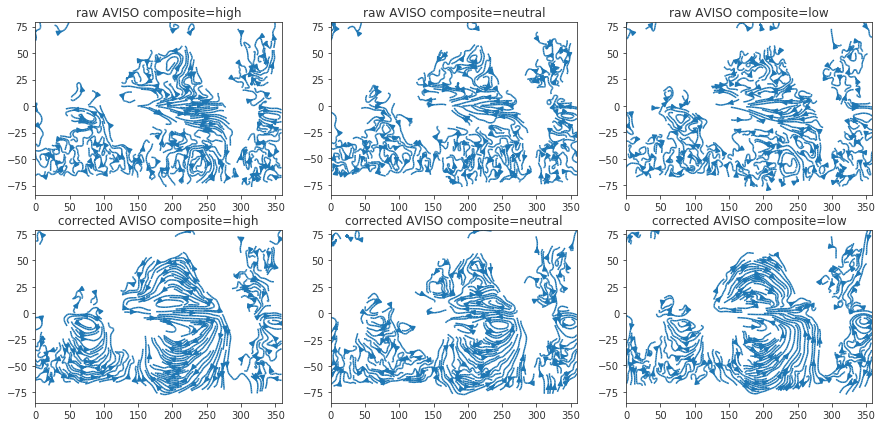

In [18]:
x = ds_vel_composite_an.XC
y = ds_vel_composite_an.YC
xx, yy = np.meshgrid(x, y)
ur = ds_vel_composite_an.ubar
vr = ds_vel_composite_an.vbar
uc = ds_vel_composite_an.ubar_corr
vc = ds_vel_composite_an.vbar_corr

plt.figure(figsize=[15, 7])
for nn in [1,4]:
    if nn == 1:
        u = ur
        v = vr
        name = 'raw AVISO'
    elif nn == 4:
        u = uc
        v = vc
        name = 'corrected AVISO'
    for ii in range(3):
        plt.subplot(2,3,nn+ii)
        plt.streamplot(xx, yy, u.isel(composite=ii), v.isel(composite=ii), density=3)
        plt.title(name+' composite=%s' %u.composite.isel(composite=ii).data)

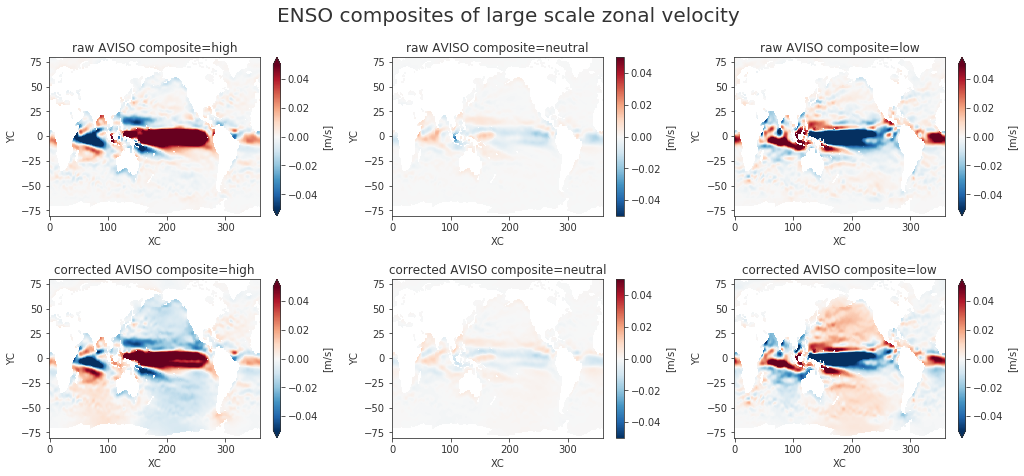

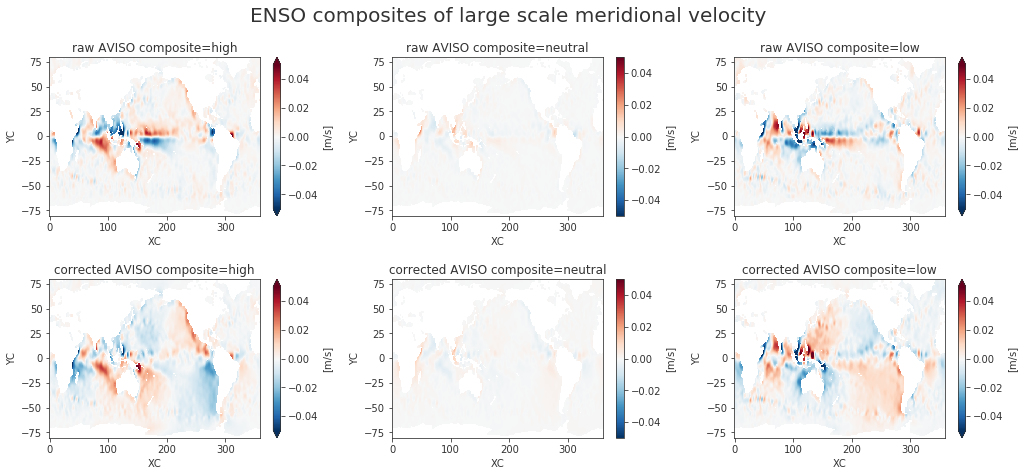

In [19]:
for pp in range(2):
    if pp == 0:
        figname='zonal'
    else:
        figname='meridional'
    fig = plt.figure(figsize=[17, 7])
    for nn in [1,4]:
        if nn == 1:
            u = ur
            v = vr
            name = 'raw AVISO'
        elif nn == 4:
            u = uc
            v = vc
            name = 'corrected AVISO'
        for ii in range(3):
            plt.subplot(2,3,nn+ii)
            if pp == 0:
                h = u.isel(composite=ii).plot(vmax=0.05)
            elif pp == 1:
                h = v.isel(composite=ii).plot(vmax=0.05)
            plt.title(name+' composite=%s' %u.composite.isel(composite=ii).data)
            h.colorbar.set_label('[m/s]')

    plt.subplots_adjust(hspace=0.4, wspace=0.3, top=0.88)
    plt.suptitle('ENSO composites of large scale %s velocity' %figname, fontsize=20)
#     fig.savefig(os.path.join(pdir,'ENSO_comp_large_scale_vel_%s.png' %figname), dpi=150)

# Preprocessing

In [20]:
validpath1 = '/rigel/home/jb3210/jb3210/projects/aviso_products/output_dir/interpolated/validmask.bin'
validpath2 = '/rigel/home/jb3210/jb3210/projects/aviso_surface_tracer/offline_velocities/aviso_DUACS2014_daily_msla/interpolated/validmask_combined.bin'
validmask_combo = xr.ufuncs.logical_and(readbin(validpath1,ds.rA.shape),
                                       readbin(validpath2,ds.rA.shape))
validmask = xr.DataArray(validmask_combo, dims=ds.rA.dims,
                         coords=ds.rA.coords)

mask = xr.open_dataarray(os.path.join(ddir,'output_new/reset_mask.nc'), decode_times=False)
# mask.time.data = ds.time.data

ds_masked = ds.where(validmask).where(abs(ds.YC)>5).where(mask)

# plt.figure(figsize=[12,8])
# plt.subplot(2,2,1)
# ds_masked['production'].isel(time=5,tracer=0, tracer_no=0).plot()
# plt.subplot(2,2,2)
# validmask.plot()
# plt.subplot(2,2,3)
# ds_masked['qbar_variance'][0,:,0].mean(['XC', 'YC']).plot()

ds_masked

<xarray.Dataset>
Dimensions:        (XC: 3600, YC: 1600, time: 292, tracer: 4, tracer_no: 2)
Coordinates:
  * tracer         (tracer) <U3 'PSI' 'LAT' 'SST' 'SSS'
  * time           (time) int64 2592000 5184000 7776000 10368000 12960000 ...
  * tracer_no      (tracer_no) int64 1 2
  * YC             (YC) float32 -79.95 -79.85 -79.75 -79.65 -79.55 -79.45 ...
  * XC             (XC) float32 0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 ...
    rA             (YC, XC) float32 2.15699e+07 2.15699e+07 2.15699e+07 ...
    Depth          (YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    hFacC          (YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
Data variables:
    production     (tracer, time, tracer_no, YC, XC) float64 dask.array<shape=(4, 292, 2, 1600, 3600), chunksize=(1, 1, 1, 1600, 3600)>
    dissipation    (tracer, time, tracer_no, YC, XC) float64 dask.array<shape=(4, 292, 2, 1600, 3600), chunksize=(1, 1, 1, 1600, 3600)>
    qbar_variance  (tracer, time, tr

In [21]:
# subset the data. I take subsamples every 10 boxes (1deg).
sub = 10
ds_sub = ds_masked.isel(XC=slice(0,None,sub), YC=slice(0,None,sub))
ds_sub = ds_sub.persist()

In [22]:
# Now deal with the zero gradients and infs in the mean
#Clean up koc dataset
ds_sub['koc'] = ds_sub['koc'].where(xr.ufuncs.isfinite(ds_sub['koc']))
ds_sub['koc'] = ds_sub['koc'].where(ds_sub['koc']>0)

In [23]:
# add mixing length
ds_sub['lmix'] = xr.ufuncs.sqrt(ds_sub['qp_variance']) / xr.ufuncs.sqrt(ds_sub['qbar_variance'])
ds_sub

<xarray.Dataset>
Dimensions:        (XC: 360, YC: 160, time: 292, tracer: 4, tracer_no: 2)
Coordinates:
  * tracer         (tracer) <U3 'PSI' 'LAT' 'SST' 'SSS'
  * time           (time) int64 2592000 5184000 7776000 10368000 12960000 ...
  * tracer_no      (tracer_no) int64 1 2
  * YC             (YC) float32 -79.95 -78.95 -77.95 -76.95 -75.95 -74.95 ...
  * XC             (XC) float32 0.05 1.05 2.05 3.05 4.05 5.05 6.05 7.05 8.05 ...
    rA             (YC, XC) float32 2.15699e+07 2.15699e+07 2.15699e+07 ...
    Depth          (YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    hFacC          (YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
Data variables:
    production     (tracer, time, tracer_no, YC, XC) float64 dask.array<shape=(4, 292, 2, 160, 360), chunksize=(1, 1, 1, 160, 360)>
    dissipation    (tracer, time, tracer_no, YC, XC) float64 dask.array<shape=(4, 292, 2, 160, 360), chunksize=(1, 1, 1, 160, 360)>
    qbar_variance  (tracer, time, tracer_no, Y

In [24]:
ds_sub = average_3m(ds_sub)
ds_sub = decode_time(ds_sub)
ds_sub

<xarray.Dataset>
Dimensions:        (XC: 360, YC: 160, time: 98, tracer: 4, tracer_no: 2)
Coordinates:
  * tracer         (tracer) <U3 'PSI' 'LAT' 'SST' 'SSS'
  * tracer_no      (tracer_no) int64 1 2
  * YC             (YC) float32 -79.95 -78.95 -77.95 -76.95 -75.95 -74.95 ...
  * XC             (XC) float32 0.05 1.05 2.05 3.05 4.05 5.05 6.05 7.05 8.05 ...
    rA             (YC, XC) float32 2.15699e+07 2.15699e+07 2.15699e+07 ...
    Depth          (YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    hFacC          (YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
  * time           (time) datetime64[ns] 1993-03-02 1993-05-31 1993-08-29 ...
Data variables:
    production     (time, tracer, tracer_no, YC, XC) float64 dask.array<shape=(98, 4, 2, 160, 360), chunksize=(1, 1, 1, 160, 360)>
    dissipation    (time, tracer, tracer_no, YC, XC) float64 dask.array<shape=(98, 4, 2, 160, 360), chunksize=(1, 1, 1, 160, 360)>
    qbar_variance  (time, tracer, tracer_no, YC, 

In [25]:
# Add residual fraction
ds_sub = residual_fraction(ds_sub)
ds_sub

<xarray.Dataset>
Dimensions:            (XC: 360, YC: 160, time: 98, tracer: 4, tracer_no: 2)
Coordinates:
  * tracer             (tracer) <U3 'PSI' 'LAT' 'SST' 'SSS'
  * tracer_no          (tracer_no) int64 1 2
  * YC                 (YC) float32 -79.95 -78.95 -77.95 -76.95 -75.95 ...
  * XC                 (XC) float32 0.05 1.05 2.05 3.05 4.05 5.05 6.05 7.05 ...
    rA                 (YC, XC) float32 2.15699e+07 2.15699e+07 2.15699e+07 ...
    Depth              (YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    hFacC              (YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
  * time               (time) datetime64[ns] 1993-03-02 1993-05-31 ...
Data variables:
    production         (time, tracer, tracer_no, YC, XC) float64 dask.array<shape=(98, 4, 2, 160, 360), chunksize=(1, 1, 1, 160, 360)>
    dissipation        (time, tracer, tracer_no, YC, XC) float64 dask.array<shape=(98, 4, 2, 160, 360), chunksize=(1, 1, 1, 160, 360)>
    qbar_variance      (time, tracer

In [26]:
def compute_kmin(ds_in):
    ds_in = ds_in.copy()
    target = harmonic_mean(ds_in['koc'], dim=['tracer_no', 'time'])
    trace = target
    kmin_diag = target
    kmin_mask = target == target.min('tracer')
    ds_in['kmin'] = harmonic_mean(ds_in['koc'].where(kmin_mask), dim=['tracer_no', 'tracer'])
    ds_in['lmixmin'] = harmonic_mean(ds_in['lmix'].where(kmin_mask), dim=['tracer_no', 'tracer'])
    return ds_in, kmin_mask, kmin_diag

In [27]:
ds_sub, mask, mask_diag = compute_kmin(ds_sub)
ds_sub

<xarray.Dataset>
Dimensions:            (XC: 360, YC: 160, time: 98, tracer: 4, tracer_no: 2)
Coordinates:
  * tracer             (tracer) <U3 'PSI' 'LAT' 'SST' 'SSS'
  * tracer_no          (tracer_no) int64 1 2
  * YC                 (YC) float32 -79.95 -78.95 -77.95 -76.95 -75.95 ...
  * XC                 (XC) float32 0.05 1.05 2.05 3.05 4.05 5.05 6.05 7.05 ...
    rA                 (YC, XC) float32 2.15699e+07 2.15699e+07 2.15699e+07 ...
    Depth              (YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    hFacC              (YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
  * time               (time) datetime64[ns] 1993-03-02 1993-05-31 ...
Data variables:
    production         (time, tracer, tracer_no, YC, XC) float64 dask.array<shape=(98, 4, 2, 160, 360), chunksize=(1, 1, 1, 160, 360)>
    dissipation        (time, tracer, tracer_no, YC, XC) float64 dask.array<shape=(98, 4, 2, 160, 360), chunksize=(1, 1, 1, 160, 360)>
    qbar_variance      (time, tracer

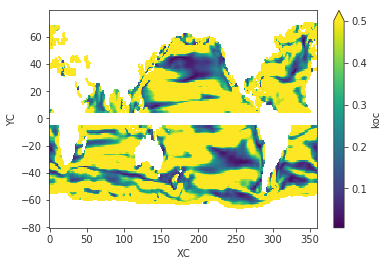

In [28]:
# Ok this is incredibly patchy. I will define some sort of criterion to look at places where the spread
# is not that large
# It turns out, that the tracers are only very similar (in their mean) in the subpropical gyres...
mask_diag = mask_diag.load()
(mask_diag.std('tracer') / mask_diag.min('tracer')).plot(vmax=0.5)

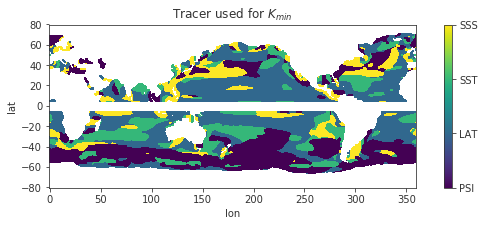

In [ ]:
# Identify which tracer is used in which location
tracer_number = mask.tracer.copy()
tracer_number.data = np.array([0,1,2,3])
tracer_number

tracer_marker = ((mask*0)+1)*tracer_number

fig = plt.figure(figsize=[10,3])
ax = plt.gca()
ax.set_aspect('equal')
h = tracer_marker.where(mask).mean('tracer').plot(ax=ax)

cbar = h.colorbar
cbar.set_ticks(tracer_number.data)
cbar.set_ticklabels(mask.tracer.data)
plt.title('Tracer used for $K_{min}$');
plt.ylabel('lat');
plt.xlabel('lon');

In [ ]:
ts_lmix = dict([])
ts_lmixmin = dict([])
for re in Boxes.keys():
    ts_lmix[re] = weighted_mean(ds_sub['lmix'].sel(**Boxes[re]), ds_sub['rA'], dim=['XC', 'YC']).load()
    ts_lmixmin[re] = weighted_mean(ds_sub['lmixmin'].sel(**Boxes[re]), ds_sub['rA'], dim=['XC', 'YC']).load()

In [ ]:
for ri, re in enumerate(Boxes.keys()):
    plt.subplot(2, 1, ri+1)
    for tn in ds.tracer_no.data:
        for ti,tr in enumerate([ds.tracer.data[1]]):
            if tn == 1:
                ls = '-'
            if tn == 2:
                ls = '--'
            (ts_lmix[re] /1000).sel(tracer=tr, tracer_no=tn).plot(color='C%i' %ti, linestyle=ls)
        if tn==1:
            plt.legend(ds.tracer.data)
        (ts_lmixmin[re] /1000).plot(color='k')
        plt.ylabel('Mixing Length [$km$]')
        plt.title(re)

In [ ]:
lmix_map = ds_sub['lmixmin'].mean(['time']).load()

In [ ]:
(lmix_map /1000).plot(vmin=100,vmax=220)

In [ ]:
# test if the lowest timeseries was picked
spot = {'XC':50, 'YC':35}
for tt in ds_sub.tracer.data:
    data = ds_sub['koc'].sel(tracer=tt).isel(**spot)
    harmonic_mean(data, dim=['tracer_no']).plot()
    
ds_sub['kmin'].isel(**spot).plot(color='k', linestyle='--')

In [ ]:
import matplotlib as mpl
plt.figure()
ax = plt.gca(facecolor='0.5')
(harmonic_mean(ds_sub['kmin'], dim='time')).plot(ax=ax, vmin=2e2, vmax=7e3, norm=mpl.colors.LogNorm())

In [ ]:
ds_final = ds_sub
ds_final

In [ ]:
ds_final = ds_final.load()
ds_final

In [ ]:
final_path = '/rigel/home/jb3210/jb3210/projects/aviso_surface_tracer/output/prototype_tracer_variance_output.nc' 
del ds_final.time.attrs['units']
ds_final.to_netcdf(final_path, engine='scipy')

In [ ]:
ds_final

# Appendix Plots

In [ ]:
# [(param, value) for param, value in plt.rcParams.items() if 'color' in param] 
# # show all plot parameters that have color as option

In [ ]:
#####################################################################
# Show the coherence between two tracers, once the reset is removed #
#####################################################################
boxname = 'South Pacific'
tracer_merge_raw = ds['dissipation'].sel(tracer='PSI', **Boxes[boxname])
tracer_merge_raw = weighted_harmonic_mean(tracer_merge_raw, tracer_merge_raw['rA'], dim=['XC', 'YC']).load()
tracer_merge_masked = ds_masked['dissipation'].sel(tracer='PSI', **Boxes[boxname])
tracer_merge_masked = weighted_harmonic_mean(tracer_merge_masked, tracer_merge_masked['rA'], dim=['XC', 'YC']).load()

In [ ]:
tracer_merge = ds_sub['dissipation'].sel(tracer='PSI', **Boxes[boxname])
tracer_merge = weighted_harmonic_mean(tracer_merge, tracer_merge['rA'], dim=['XC', 'YC']).load()

In [ ]:
plt.figure(figsize=[8,6])
plt.subplot(2,1,1)
tracer_merge_raw.isel(tracer_no=0).plot(color='C0',linestyle=':')
tracer_merge_raw.isel(tracer_no=1).plot(color='C1',linestyle=':')
tracer_merge_masked.isel(tracer_no=0).plot(color='C0',)
tracer_merge_masked.isel(tracer_no=1).plot(color='C1',)

plt.subplot(2,1,2)
tracer_merge.isel(tracer_no=0).plot()
tracer_merge.isel(tracer_no=1).plot()

plt.subplots_adjust(hspace=0.3)
plt.gcf().savefig('tracer_no_merge_reset.pdf')

In [ ]:
# Balance between diss and production
ds_mean_map = ds_final.mean(['tracer_no', 'time']).load()
# average the koc with harmonic mean
ds_mean_map['koc'] = harmonic_mean(ds_final['koc'], dim=['tracer_no', 'time']).load()

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=[25,10])
for ti, tr in enumerate(ds_mean_map.tracer.data):
    for fi, fl in enumerate(['residual_fraction', 'dissipation', 'production', 'koc']):
        ax = axes[fi,ti]
        ax.set_facecolor('0.5')
        kw = dict([])
        if fi == 0:
            kw['cmap']=plt.cm.BrBG_r
            kw['levels'] = 9
            kw['vmax'] = 1
            kw['vmin'] = 0
        elif fi == 3:
            kw['cmap']=plt.cm.viridis
            kw['vmax'] = 8e3
            kw['vmin'] = 2e2
        else:
            kw['cmap']=plt.cm.RdBu_r
            if ti == 0:
                kw['vmax'] = 3e-10
            elif ti == 1: 
                kw['vmax'] = 8e-7
            elif ti == 2: 
                kw['vmax'] = 1e-7
            elif ti == 3: 
                kw['vmax'] = 8e-9
            kw['vmin'] = -kw['vmax']

        ds_mean_map[fl].sel(tracer=tr).plot(ax=ax, robust=True, **kw)

# Compute box timeseries (move up top)

In [ ]:
ts_koc = dict([])
ts_kmin = dict([])
ts_dissipation = dict([])
ts_production = dict([])
ts_eke_corr = dict([])
ts_eke = dict([])
ts_ubar_corr = dict([])
ts_ubar = dict([])
ts_kmix = dict([])
for re in Boxes.keys():
    ts_koc[re] = weighted_harmonic_mean(ds_final['koc'].sel(**Boxes[re]),
                                        ds_final['rA'], dim=['XC', 'YC']).load()
    ts_kmin[re] = weighted_harmonic_mean(ds_final['kmin'].sel(**Boxes[re]),
                                        ds_final['rA'], dim=['XC', 'YC']).load()
    ts_dissipation[re] = weighted_mean(ds_final['dissipation'].sel(**Boxes[re]),
                                       ds_final['rA'], dim=['XC', 'YC']).load()
    ts_production[re] = weighted_mean(ds_final['production'].sel(**Boxes[re]),
                                      ds_final['rA'], dim=['XC', 'YC']).load()
    ts_eke_corr[re] = weighted_mean(ds_vel['eke_corr'].sel(**Boxes[re]),
                                      ds_final['rA'], dim=['XC', 'YC']).load()
    ts_eke[re] = weighted_mean(ds_vel['eke'].sel(**Boxes[re]),
                                      ds_final['rA'], dim=['XC', 'YC']).load()
    ts_ubar_corr[re] = weighted_mean(ds_vel['ubar_corr'].sel(**Boxes[re]),
                                      ds_final['rA'], dim=['XC', 'YC']).load()
    ts_ubar[re] = weighted_mean(ds_vel['ubar'].sel(**Boxes[re]),
                                      ds_final['rA'], dim=['XC', 'YC']).load()
    ts_kmix[re] = weighted_mean(ds_supression['K_mix_min'].sel(**Boxes[re]),
                                      ds_final['rA'], dim=['XC', 'YC']).load()

In [ ]:
ts_eke_corr[re].plot()

In [ ]:
####################################
# Compare Kmin to tracers in boxes #
####################################

plt.figure(figsize=[10,6])
for ri, re in enumerate(Boxes.keys()):
    plt.subplot(2, 1, ri+1)
    for tn in ds.tracer_no.data:
        for ti,tr in enumerate(ds.tracer.data):
            if tn == 1:
                ls = '-'
            if tn == 2:
                ls = '--'
            ts_koc[re].sel(tracer=tr, tracer_no=tn).plot(color='C%i' %ti, linestyle=ls)
        ts_kmin[re].plot(color='k')
        if tn==1:
            plt.legend(ds.tracer.data)
        
        plt.ylabel('Surface Diffusivity [$m^2/s$]')
        plt.title(re)
plt.gcf().savefig('kmin_tracer_comparison_timeseries.png', dpi=300)

In [ ]:
plt.figure(figsize=[16,6])
re = 'North Pacific'
tr = 'LAT'
plt.subplot(2,4,1)
ts_dissipation[re].sel(tracer=tr).mean('tracer_no').plot(color='C0')
(-ts_production[re]).sel(tracer=tr).mean('tracer_no').plot(color='C1')
plt.legend(['dissipation', 'production'])
plt.ylabel(re)

tr = 'PSI'
plt.subplot(2,4,2)
ts_dissipation[re].sel(tracer=tr).mean('tracer_no').plot(color='C0')
(-ts_production[re]).sel(tracer=tr).mean('tracer_no').plot(color='C1')

tr = 'SSS'
plt.subplot(2,4,3)
ts_dissipation[re].sel(tracer=tr).mean('tracer_no').plot(color='C0')
(-ts_production[re]).sel(tracer=tr).mean('tracer_no').plot(color='C1')

tr = 'SST'
plt.subplot(2,4,4)
ts_dissipation[re].sel(tracer=tr).mean('tracer_no').plot(color='C0')
(-ts_production[re]).sel(tracer=tr).mean('tracer_no').plot(color='C1')

re = 'South Pacific'
tr = 'LAT'
plt.subplot(2,4,5)
ts_dissipation[re].sel(tracer=tr).mean('tracer_no').plot(color='C0')
(-ts_production[re]).sel(tracer=tr).mean('tracer_no').plot(color='C1')
# legend('dissipation', 'production')
plt.ylabel(re)

tr = 'PSI'
plt.subplot(2,4,6)
ts_dissipation[re].sel(tracer=tr).mean('tracer_no').plot(color='C0')
(-ts_production[re]).sel(tracer=tr).mean('tracer_no').plot(color='C1')

tr = 'SSS'
plt.subplot(2,4,7)
ts_dissipation[re].sel(tracer=tr).mean('tracer_no').plot(color='C0')
(-ts_production[re]).sel(tracer=tr).mean('tracer_no').plot(color='C1')

tr = 'SST'
plt.subplot(2,4,8)
ts_dissipation[re].sel(tracer=tr).mean('tracer_no').plot(color='C0')
(-ts_production[re]).sel(tracer=tr).mean('tracer_no').plot(color='C1')
plt.subplots_adjust(hspace=0.4)
plt.gcf().savefig('prod_diss_balance.png', dpi=300)

In [ ]:
def RMSE_harmonic(ds, error_dim, mean_dim='time'):
    mean = harmonic_mean(ds, dim=error_dim)
    an = ds - mean
    an_sq = an ** 2
    mse = harmonic_mean(an_sq, dim=mean_dim)
    return xr.ufuncs.sqrt(mse)

# RMSE between tracers
- # The RMSE had a bug! Document

In [ ]:
RMSE_total = RMSE_harmonic(ds_final['koc'], ['tracer', 'tracer_no']).load()
RMSE = RMSE_harmonic(ds_final['koc'], ['tracer', 'tracer_no'], mean_dim=['time', 'tracer', 'tracer_no']).load()
KOC_ref = harmonic_mean(ds_final['koc'], ['tracer', 'tracer_no', 'time']).load()

In [ ]:
RMSE_total.max('tracer_no').plot(col='tracer', vmax=500)

In [ ]:
RMSE.plot(vmax=500)

In [ ]:
(RMSE_total / KOC_ref).max('tracer_no').plot(col='tracer',vmax=0.2)

In [ ]:
(RMSE / KOC_ref *100).plot(vmax=10, cmap=plt.cm.Reds)

# Master Plots

In [ ]:
def xarray_norm(in_a, norm_a):
    out_norm = ((in_a - np.nanmean(in_a.data)) / np.nanstd(in_a.data) *
                np.nanstd(norm_a)) + np.nanmedian(norm_a)
    return out_norm

def xarray_removeSeasonal(da, groupspec='time.month', func=harmonic_mean):
    print('choose the mean function appropriate!!!')
    mean = func(da, 'time')
    season_removed = da.groupby(groupspec).apply(
        lambda x: x - func(x, 'time'), shortcut=False) + mean
    return season_removed.drop(groupspec[5:])

In [ ]:
# Load ENSO index (TODO maybe update befor the final release)
ENSO = xr.open_dataset('/rigel/home/jb3210/jb3210/shared_data/climate_indicies/ENSO.nc')

ENSO_1M = ENSO.reindex_like(ds_vel, method='nearest') #TODO not sure if this is the best for the correlation...ask Ryan...the signal should be strong anyways
ENSO_3M = ENSO.resample(time='3M').mean().reindex_like(ds_final, method='nearest') #TODO not sure if this is the best for the correlation...ask Ryan...the signal should be strong anyways


ENSO_1M.NINO34.plot()
ENSO_3M.NINO34.plot()

In [ ]:
# from xarrayutils.plotting import box_plot

# Just a temp fix
def box_plot(box, ax=None, split_detection='True', **kwargs):
    """plots box despite coordinate discontinuities.
    INPUT
    -----
    box: np.array
        Defines the box in the coordinates of the current axis.
        Describing the box corners [x1, x2, y1, y2]
    ax: matplotlib.axis
        axis for plotting. Defaults to plt.gca()
    kwargs: optional
        anything that can be passed to plot can be put as kwarg
    """

    if len(box) != 4:
        raise RuntimeError("'box' must be a 4 element np.array, \
            describing the box corners [x1, x2, y1, y2]")
    xlim = plt.gca().get_xlim()
    ylim = plt.gca().get_ylim()
    x_split = False
    y_split = False

    if ax is None:
        ax = plt.gca()

    if split_detection:
        if np.diff([box[0], box[1]]) < 0:
            x_split = True

        if np.diff([box[2], box[3]]) < 0:
            y_split = True

    if y_split and not x_split:
        ax.plot([box[0], box[0], box[1], box[1], box[0]],
                 [ylim[1], box[2], box[2], ylim[1], ylim[1]], **kwargs)

        ax.plot([box[0], box[0], box[1], box[1], box[0]],
                 [ylim[0], box[3], box[3], ylim[0], ylim[0]], **kwargs)

    elif x_split and not y_split:
        ax.plot([xlim[1], box[0], box[0], xlim[1], xlim[1]],
                 [box[2], box[2], box[3], box[3], box[2]], **kwargs)

        ax.plot([xlim[0], box[1], box[1], xlim[0], xlim[0]],
                 [box[2], box[2], box[3], box[3], box[2]], **kwargs)

    elif x_split and y_split:
        ax.plot([xlim[1], box[0], box[0]], [box[2], box[2], ylim[1]],
                 **kwargs)

        ax.plot([xlim[0], box[1], box[1]], [box[2], box[2], ylim[1]],
                 **kwargs)

        ax.plot([xlim[1], box[0], box[0]], [box[3], box[3], ylim[0]],
                 **kwargs)

        ax.plot([xlim[0], box[1], box[1]], [box[3], box[3], ylim[0]],
                 **kwargs)

    elif not x_split and not y_split:
        plt.plot([box[0], box[0], box[1], box[1], box[0]],
                 [box[2], box[3], box[3], box[2], box[2]], **kwargs)


In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as feat
import matplotlib as mpl
projection = ccrs.Robinson(central_longitude=200)

In [ ]:
def apply_harm_mean_time(da, axis=None):
    return harmonic_mean(da, dim='time')

mean_kmin = harmonic_mean(ds_final['kmin'], dim='time')
mean_kmin.attrs['title'] = 'Surface Diffusivity time average'
mean_kmin.attrs['units'] = '[$m^2/s$]'
mean_kmin.attrs['plotname'] = 'kmin_mean%s.png'
mean_kmin.attrs['vmin'] = 1e2
mean_kmin.attrs['vmax'] = 1e4

annual_kmin = ds_final['kmin'].resample(time='1A').apply(apply_harm_mean_time)

kmin_annual_range = annual_kmin.quantile(0.90, 'time') - annual_kmin.quantile(0.10, 'time')
kmin_annual_range.attrs['title'] = 'Surface Diffusivity annual range'
kmin_annual_range.attrs['units'] = '[$m^2/s$]'
kmin_annual_range.attrs['plotname'] = 'kmin_annual_range%s.png'
kmin_annual_range.attrs['vmin'] = 1e2
kmin_annual_range.attrs['vmax'] = 1e4


ratio_kmin = (annual_range_kmin / mean_kmin)
ratio_kmin.attrs['title'] = 'Ratio of inteannual range to mean diffusivity'
ratio_kmin.attrs['units'] = ''
ratio_kmin.attrs['plotname'] = 'kmin_ratio%s.png'
ratio_kmin.attrs['vmin'] = 0.25
ratio_kmin.attrs['vmax'] = 1


for plot_boxes in ['_w_boxes', '']:
    for data in [mean_kmin, kmin_annual_range, ratio_kmin]:
        kw = dict([])
        if data.attrs['units'] == '':
            kw['levels'] = 6
        else:
            kw['norm'] = mpl.colors.LogNorm()

        
        plt.figure(figsize=np.array([20,6])*2/3)
        ax = plt.axes(projection=projection)
        data.plot(ax=ax, transform=ccrs.PlateCarree(),
                  vmin=data.attrs['vmin'],
                  vmax=data.attrs['vmax'],
                  cbar_kwargs={'label':data.attrs['units'],},
                 **kw)
        if plot_boxes == '_w_boxes':
            box_plot([170, 225, 15, 45],
                     transform=ccrs.PlateCarree(), color='k')
            box_plot([210, 280, -45, -15],
                     transform=ccrs.PlateCarree(), color='k')

        ax.add_feature(feat.LAND, facecolor='0.8')
        ax.gridlines()
        ax.outline_patch.set_edgecolor(ax_color)
        plt.title('Surface Diffusivity interannual range')
        plt.gcf().savefig(data.attrs['plotname'] %plot_boxes, dpi=300)

In [ ]:
####################################
# mean diffusivity for each tracer #
####################################

mean_koc = harmonic_mean(ds_final['koc'], dim=['time', 'tracer_no'])

p = mean_koc.plot(transform=ccrs.PlateCarree(), col='tracer', figsize=np.array([15,8])*2/3, 
                  col_wrap=2, vmin=1e2,vmax=1e4,
                  norm=mpl.colors.LogNorm(),subplot_kws={'projection': projection,})
for ax in p.axes.flat:
    ax.add_feature(feat.LAND, facecolor='0.8')
    # ax.coastlines();
    ax.gridlines()
plt.gcf().savefig('koc_mean-all_tracer.png', dpi=300)

In [ ]:
###################
# Timeseries plot #
###################

plt.figure(figsize=[10,6])
for ri, re in enumerate(Boxes.keys()):
    plt.subplot(2, 1, ri+1)
    ts_kmin[re].plot(color='k', label='Surface Diffusivity')
    xarray_removeSeasonal(xarray_norm(ts_eke_corr[re], ts_kmin[re])).plot(color='C1', label='scaled EKE (seasonal cycle removed)')
    xarray_norm(ENSO_3M.NINO34, ts_kmin[re]).plot(color='C2', label='scaled NINO3.4')
    plt.ylabel('Surface Diffusivity [$m^2/s$]')
    plt.title(re)
plt.legend()
plt.gcf().savefig('kmin_timeseries.png', dpi=300)

# Version with velocities
plt.figure(figsize=[10,6])
for ri, re in enumerate(Boxes.keys()):
    plt.subplot(2, 1, ri+1)
    ts_kmin[re].plot(color='k')
    xarray_norm(ENSO_3M.NINO34, ts_kmin[re]).plot(color='C2',label='K_min')
    
    xarray_removeSeasonal(xarray_norm(ts_eke_corr[re], ts_kmin[re])).plot(color='C1', label='EKE (seasonal cycle removed)')
#     xarray_removeSeasonal(xarray_norm(ts_eke[re], ts_kmin[re])).plot(color='C1', linestyle='--')
    
    (ts_kmix[re]*2).plot(color='C3', label='K_mix x2')
#     xarray_norm(ts_kmix[re], ts_kmin[re]).plot(color='C3')
#     xarray_norm(ts_ubar[re], ts_kmin[re]).plot(color='C3', linestyle='--')
    plt.ylabel('Surface Diffusivity [$m^2/s$]')
    plt.title(re)
plt.legend()
plt.gcf().savefig('kmin_timeseries_with_Kmix_raw.png', dpi=300)

# Version with velocities
plt.figure(figsize=[10,6])
for ri, re in enumerate(Boxes.keys()):
    plt.subplot(2, 1, ri+1)
    ts_kmin[re].plot(color='k')
    xarray_norm(ENSO_3M.NINO34, ts_kmin[re]).plot(color='C2',label='K_min')
    
    xarray_removeSeasonal(xarray_norm(ts_eke_corr[re], ts_kmin[re])).plot(color='C1', label='EKE (seasonal cycle removed)')

    xarray_norm(ts_kmix[re], ts_kmin[re]).plot(color='C3', label='K_mix')
    plt.ylabel('Surface Diffusivity [$m^2/s$]')
    plt.title(re)
plt.legend()
plt.gcf().savefig('kmin_timeseries_with_Kmix.png', dpi=300)

choose the mean function appropriate!!!
choose the mean function appropriate!!!


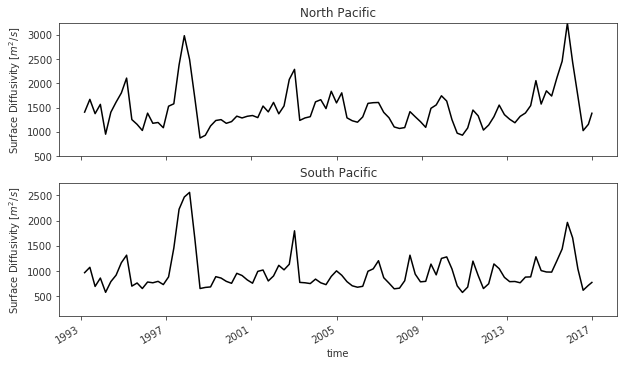

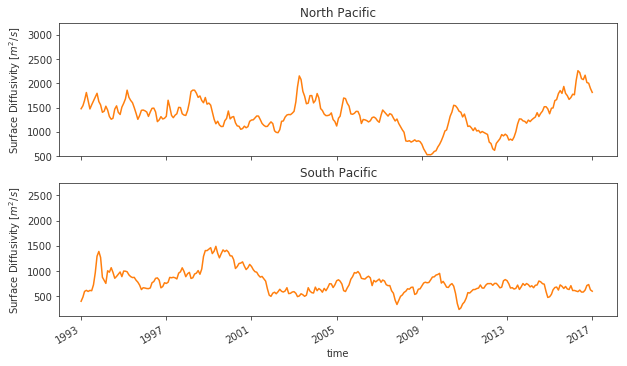

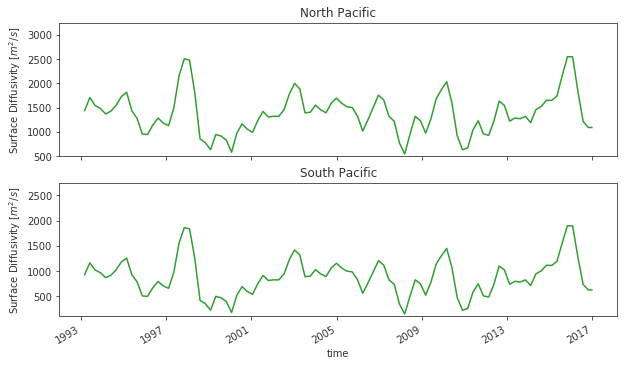

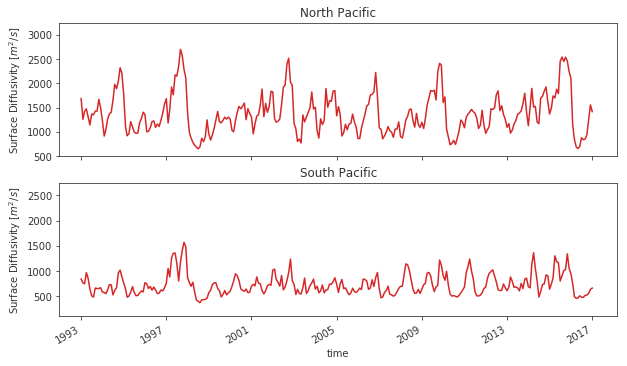

In [69]:
#################################
# seperated timeseries for talk #
#################################
for line in range(4):
    plt.figure(figsize=[10,6])
    for ri, re in enumerate(Boxes.keys()):
        
        plt.subplot(2, 1, ri+1)
        if line == 0:
            ts_kmin[re].plot(color='k', label='Surface Diffusivity')
            xlim = plt.gca().get_xlim()
        elif line == 1:
            xarray_removeSeasonal(xarray_norm(ts_eke_corr[re], ts_kmin[re])).plot(color='C1', label='scaled EKE (seasonal cycle removed)')
        elif line == 2:
            xarray_norm(ENSO_3M.NINO34, ts_kmin[re]).plot(color='C2', label='scaled NINO3.4')
        elif line == 3:
            (ts_kmix[re]*2).plot(color='C3', label='K_mix x2')
        
        if ri == 0:
            plt.gca().set_ylim(500, 3250)
        elif ri == 1:
            plt.gca().set_ylim(100, 2750)
        plt.gca().set_xlim(xlim)
        plt.ylabel('Surface Diffusivity [$m^2/s$]')
        plt.title(re)
    plt.gcf().savefig('kmin_timeseries_sep_%i.png' %line, dpi=300)

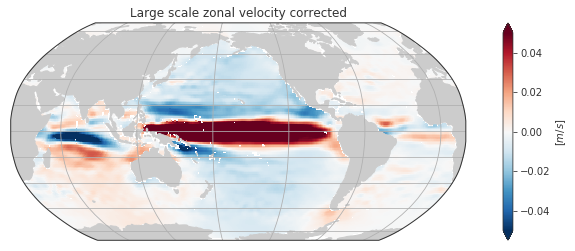

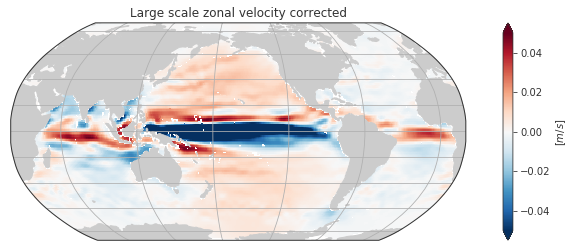

In [76]:
###################
# composite plots #
###################

kmin = ds_final['kmin']
kmin.attrs['kw'] = dict(vmax=1000, cbar_kwargs={'label':'[$m^2/s$]'})
kmin.attrs['title'] = '$K_{min}$'
kmin.attrs['plottitle'] = 'kmin'

kmix = ds_supression['K_mix_min']
kmix.attrs['kw'] = dict(vmax=400, cbar_kwargs={'label':'[$m^2/s$]'})
kmix.attrs['title'] = '$K_{mix}$'
kmix.attrs['plottitle'] = 'kmix'

lmix_tracer = ds_final['lmixmin']/1000
lmix_tracer.attrs['kw'] = dict(vmax=30, cbar_kwargs={'label':'[km]'})
lmix_tracer.attrs['title'] = '$L_{mix}$ from tracer experiment'
lmix_tracer.attrs['plottitle'] = 'lmix_tracer'

lmix_theory = ds_supression['L_mix_x']/1000
lmix_theory.attrs['kw'] = dict(vmax=30, cbar_kwargs={'label':'[km]'})
lmix_theory.attrs['title'] = '$L_{mix}$ from mean flow supression'
lmix_theory.attrs['plottitle'] = 'lmix_theory'

ubar_corr = ds_vel['ubar_corr']
ubar_corr.attrs['kw'] = dict(vmax=0.05, cbar_kwargs={'label':'[$m/s$]'})
ubar_corr.attrs['title'] = 'Large scale zonal velocity corrected'
ubar_corr.attrs['plottitle'] = 'ubar_corrected'

ubar = ds_vel['ubar']
ubar.attrs['kw'] = dict(vmax=0.05, cbar_kwargs={'label':'[$m/s$]'})
ubar.attrs['title'] = 'Large scale zonal velocity'
ubar.attrs['plottitle'] = 'ubar'

vbar_corr = ds_vel['vbar_corr']
vbar_corr.attrs['kw'] = dict(vmax=0.05, cbar_kwargs={'label':'[$m/s$]'})
vbar_corr.attrs['title'] = 'Large scale meridional velocity corrected'
vbar_corr.attrs['plottitle'] = 'vbar_corrected'

vbar = ds_vel['vbar']
vbar.attrs['kw'] = dict(vmax=0.05, cbar_kwargs={'label':'[$m/s$]'})
vbar.attrs['title'] = 'Large scale meridional velocity'
vbar.attrs['plottitle'] = 'vbar'

eke_corr = ds_vel['eke_corr']
eke_corr.attrs['kw'] = dict(vmax=0.015, cbar_kwargs={'label':'[$m^s/s^2$]'})
eke_corr.attrs['title'] = 'EKE corrected'
eke_corr.attrs['plottitle'] = 'eke_corrected'

eke = ds_vel['eke']
eke.attrs['kw'] = dict(vmax=0.015, cbar_kwargs={'label':'[$m^2/s^2$]'})
eke.attrs['title'] = 'EKE'
eke.attrs['plottitle'] = 'eke'


for comp in ['high', 'low']:
    for data in [ubar_corr]:
#     for data in [kmin, kmix, lmix_tracer, lmix_theory,
#                  ubar_corr, ubar, vbar_corr, vbar,
#                  eke_corr, eke]:

        if len(data.time)==98:
            ENSO = ENSO_3M
        elif len(data.time)==289:
            ENSO = ENSO_1M
        else:
            raise RuntimeError('Fugggg')

        xr.testing.assert_equal(ENSO.time, data.time)

        data_comp = composite(data, ENSO.NINO34, np.array([-1, 1])*0.75).mean('time')
        data_comp_an = data_comp - data.mean('time')

        plt.figure(figsize=np.array([20,6])*2/3)
        ax = plt.axes(projection=projection)
        data_comp_an.sel(composite=comp).plot(ax=ax,
                                                transform=ccrs.PlateCarree(),
                                                **data.attrs['kw'])

        ax.add_feature(feat.LAND, facecolor='0.8')
        ax.gridlines()
        ax.outline_patch.set_edgecolor(ax_color)
        plt.title(data.attrs['title'])
        plt.gcf().savefig('enso_comp_%s_%s.png' %(comp,data.attrs['plottitle']), dpi=300)

In [1]:
# plot correlation
#TODO...develop this into the new xarrayutils routune...but it has to be compatible to the old ones.(calculate linear trend in cm2.6)
from xarrayutils.utils import xr_linregress
# from scipy.stats import linregress
# def _linregress_ufunc(a,b):
#     if xr.ufuncs.isnan(a).all() or xr.ufuncs.isnan(b).all():
#         slope = np.nan
#         intercept = np.nan
#         r_value = np.nan
#         p_value = np.nan
#         std_err = np.nan
#     else:
#         slope, intercept, r_value, p_value, std_err = linregress(a,b)
#     return np.array([slope, intercept, r_value, p_value, std_err])

# def xr_linregress(a,b, dim='time'):
#     stats = xr.apply_ufunc(_linregress_ufunc, a, b,
#                           input_core_dims = [[dim], [dim]],
#                           output_core_dims = [['parameter']],
#                           vectorize = True,
#                           dask = 'parallelized',
#                           output_dtypes = [a.dtype],
#                           output_sizes = {'parameter':5}
#                           )
#     stats['parameter'] = xr.DataArray(['slope', 'intercept', 'r_value', 'p_value', 'std_err'], dims =['parameter'])
#     # chug them all into a dataset
#     ds_stats = xr.Dataset()
#     for ff in stats.parameter.data:
#         ds_stats[ff] = stats.sel(parameter=ff)
#     return ds_stats

ImportError: cannot import name 'xr_linregress'

In [209]:
corr = xr_linregress(ENSO['NINO34'], ds_final['kmin'].chunk({'time': len(ds_final.time)}).fillna(0)).load()
corr

<xarray.Dataset>
Dimensions:    (XC: 360, YC: 160)
Coordinates:
  * YC         (YC) float32 -79.95 -78.95 -77.95 -76.95 -75.95 -74.95 -73.95 ...
  * XC         (XC) float32 0.05 1.05 2.05 3.05 4.05 5.05 6.05 7.05 8.05 ...
    rA         (YC, XC) float32 2.15699e+07 2.15699e+07 2.15699e+07 ...
    Depth      (YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    hFacC      (YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    parameter  <U9 'std_err'
Data variables:
    slope      (YC, XC) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    intercept  (YC, XC) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    r_value    (YC, XC) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    p_value    (YC, XC) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    std_err    (YC, XC) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

In [231]:
corr_lmix = xr_linregress(ENSO['NINO34'], ds_final['lmixmin'].chunk({'time': len(ds_final.time)}).fillna(0)).load()
corr_lmix

<xarray.Dataset>
Dimensions:    (XC: 360, YC: 160)
Coordinates:
  * YC         (YC) float32 -79.95 -78.95 -77.95 -76.95 -75.95 -74.95 -73.95 ...
  * XC         (XC) float32 0.05 1.05 2.05 3.05 4.05 5.05 6.05 7.05 8.05 ...
    rA         (YC, XC) float32 2.15699e+07 2.15699e+07 2.15699e+07 ...
    Depth      (YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    hFacC      (YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    parameter  <U9 'std_err'
Data variables:
    slope      (YC, XC) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    intercept  (YC, XC) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    r_value    (YC, XC) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    p_value    (YC, XC) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    std_err    (YC, XC) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

In [207]:
a = ds_final['kmin'].sel(XC=160, YC=35, method='nearest').load()
b = ENSO['NINO34'].load()

In [208]:
print(_linregress_ufunc(a,b))
print(a)

[ nan  nan  nan  nan  nan]
<xarray.DataArray 'kmin' (time: 98)>
array([  2554.777854,   4271.762786,   4729.114627,   3155.584398,
         2498.646489,   2597.567665,   7232.128149,   5103.993125,
         5403.863581,   5400.191597,   4147.856566,   2888.585028,
         6361.000104,   2674.731013,   3722.476071,   2689.109945,
         2635.049491,   2950.103255,   8459.077273,  10822.673358,
         2887.786378,   2075.332751,   2074.843078,   4604.290546,
         1772.998255,   1780.935508,   4238.459029,   1855.879074,
         2040.487898,   2013.522063,   2421.78651 ,   2551.420722,
         2224.603625,   3004.99444 ,   3977.583296,   3727.547317,
         2464.557037,   1729.649556,   2638.801813,   6312.648805,
         3492.482322,   2370.459622,   3231.575217,   2858.772625,
         2988.762493,   2152.829628,   3487.57509 ,   5418.06859 ,
         5773.799122,   2979.158264,   3145.579821,   2856.034741,
         3189.037321,   2414.857101,   3874.6952  ,   6170.316284

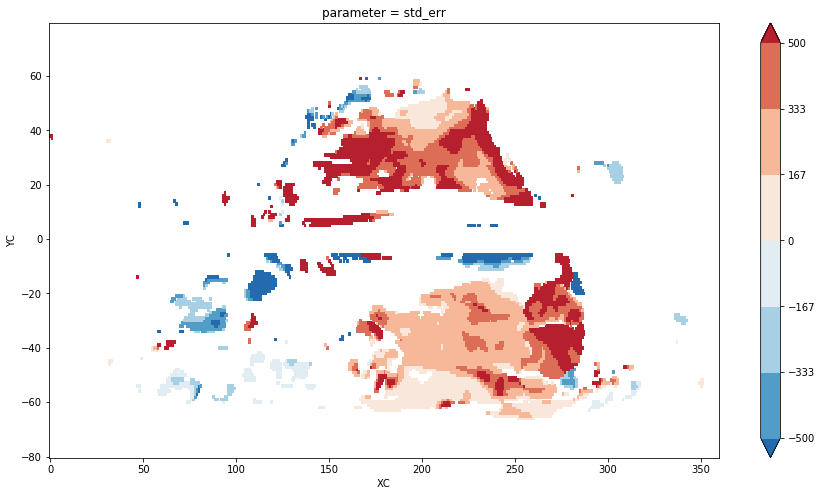

In [227]:
plt.figure(figsize=[15,8])
(corr['slope'].where(corr['p_value']<0.001)).plot(vmax=500, levels=7)
plt.plot(a.XC.data, a.YC.data)

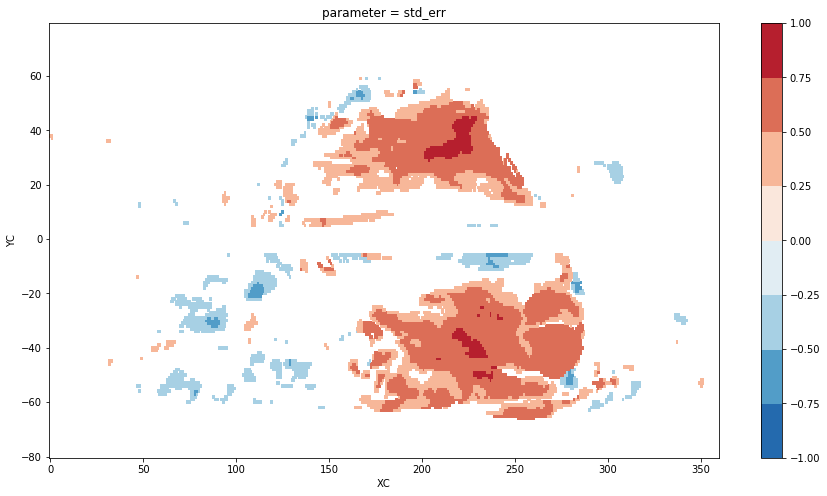

In [222]:
plt.figure(figsize=[15,8])
# ax = plt.gca(facecolor='0.5')
(corr['r_value'].where(corr['p_value']<0.001)).plot(levels=9)
plt.plot(a.XC.data, a.YC.data)

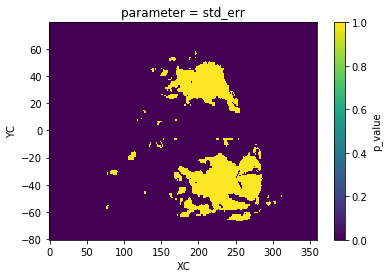

In [211]:
ax = plt.gca(facecolor='0.5')
(corr['p_value']<0.000001).plot()